# STA365 Homework 7

### Q1: derive the following

1. $p(\boldsymbol \beta | \textbf{y}, \textbf{X}, \Sigma=\sigma^2 I)$ for the **linear regression model** likelihood proportional to $\exp \left(-{\frac {1}{2}}(\mathbf {y} -\mathbf{X\boldsymbol \beta})^\top \Sigma^{-1}(\mathbf {y} - \mathbf{X\boldsymbol\beta})\right)$ and a $\mathcal{MVN}(\boldsymbol\beta_0, \boldsymbol\Sigma_\beta)$ for $\boldsymbol\beta$

2. The analytical posterior distribution for $\sigma^2$ the **error variance** of a **linear regression model** with **design matrix** $\mathbf{X}$ assuming $\sigma^2$ has an **inverse-gamma** prior distribution with parameters $\alpha^*$ and $\beta^*$ (unrelated to $\boldsymbol \beta$).

#### [Optional] Q1 Extra: derive the following

Show that for $s_i=1$ and **hyperparameters** $b_i=0$ (ignoring normalizing proportionality constants) the log posterior distributions for $\beta$ using either **normal** or **Laplace** prior distributions have analagous forms to the **ridge** and **lasso** loss functions.

*Note though that Bayesians do not optimize posterior distributions, they sample from them; but, nonetheless, the posterior distributions serve to provided 'regularizeations' of the likelihood through the prior.*

![](img/hw7_q1_1.jpg)
![](img/hw7_q1_2.jpg)

### Q2: perform Bayesian Linear Regression

- For any data set you find interesting (perhaps from kaggle.com?)
- Use an appropriate non **inverse-gamma** prior for `sigma` 
- Use `pm.Normal('betas', mu=0, sigma=1, shape=p)` rather than a `pm.MvNormal` alternative
- Use `pm.Normal('y', mu=X@betas, sigma=sigma, observed=y)` rather than `pm.MvNormal` alternative
- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### [Optional] Q2 Extra: perform generalized Bayesian Linear Regression

Replace the residual distribution and use an appropriate link function

In [1]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load NHL dataset
df = pd.read_csv("nhl_data.csv", low_memory=False) 

# Select relevant columns
columns = ['time_to_entry', 'time_to_permanence', 'player_dob_quartiles',  'draft_overall', 'player_position', 'BMI', 'country', 'shootsCatches']
df = df[columns].dropna()

# One-hot encode categorical variables (e.g., league)
df = pd.get_dummies(df, columns=['player_dob_quartiles'], drop_first=True)
df = pd.get_dummies(df, columns=['player_position'], drop_first=True)
df = pd.get_dummies(df, columns=['country'], drop_first=True)
df = pd.get_dummies(df, columns=['shootsCatches'], drop_first=True)

# Standardize the predictors
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=['time_to_entry', 'time_to_permanence']))

# Define targets
y_entry = df['time_to_entry'].values
y_permanence = df['time_to_permanence'].values

In [2]:
with pm.Model() as entry_model:
    # Priors
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model
    mu = pm.math.dot(X, betas)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_entry)

    # MCMC sampling
    entry_trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


In [3]:
with pm.Model() as permanence_model:
    # Priors
    betas = pm.Normal('betas', mu=0, sigma=1, shape=X.shape[1])
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Linear model
    mu = pm.math.dot(X, betas)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_permanence)

    # MCMC sampling
    permanence_trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 4 seconds.


Entry Model Summary:
             mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
betas[0]    4.852  0.175     4.508      5.189      0.001    0.001   15865.0   
betas[1]   -1.043  0.179    -1.410     -0.712      0.001    0.001   15389.0   
betas[2]   -0.325  0.192    -0.717      0.037      0.002    0.001   13045.0   
betas[3]   -0.770  0.188    -1.142     -0.406      0.002    0.001   14114.0   
betas[4]   -0.664  0.189    -1.059     -0.317      0.002    0.001   14128.0   
betas[5]   -0.307  0.184    -0.671      0.048      0.002    0.001   14420.0   
betas[6]   -0.985  0.186    -1.342     -0.616      0.001    0.001   15786.0   
betas[7]   -0.434  0.172    -0.790     -0.112      0.001    0.001   17016.0   
betas[8]   -0.393  0.175    -0.724     -0.042      0.001    0.001   14260.0   
betas[9]   -0.740  0.172    -1.084     -0.407      0.001    0.001   17197.0   
betas[10]  -0.141  0.173    -0.497      0.189      0.001    0.002   17682.0   
betas[11]  -0.204  0.172    -0.

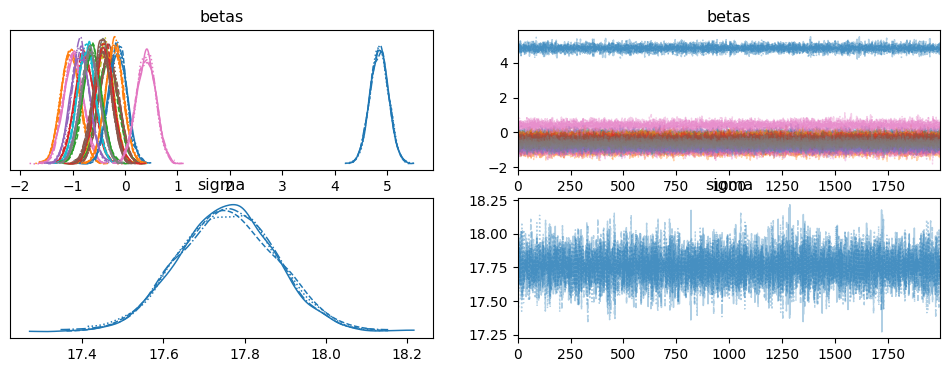

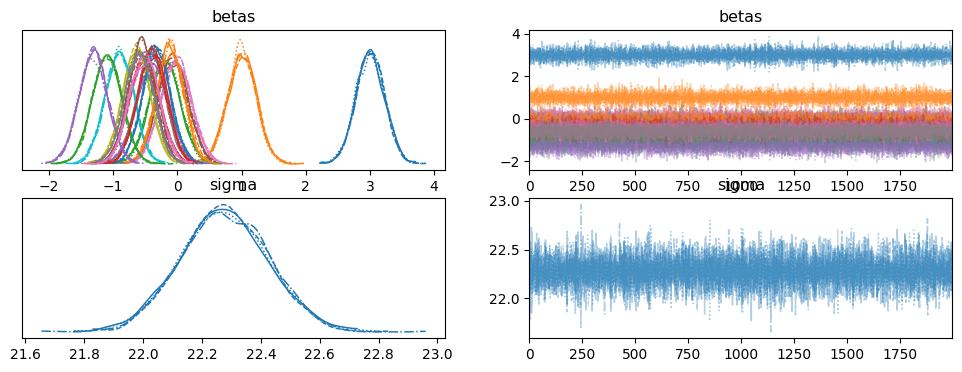

In [4]:
# Summary statistics
print("Entry Model Summary:")
print(az.summary(entry_trace, hdi_prob=0.95))

print("\nPermanence Model Summary:")
print(az.summary(permanence_trace, hdi_prob=0.95))

# Trace plots
az.plot_trace(entry_trace)
plt.show()

az.plot_trace(permanence_trace)
plt.show()

Sampling: [y_obs]


Output()

/Users/yiru/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


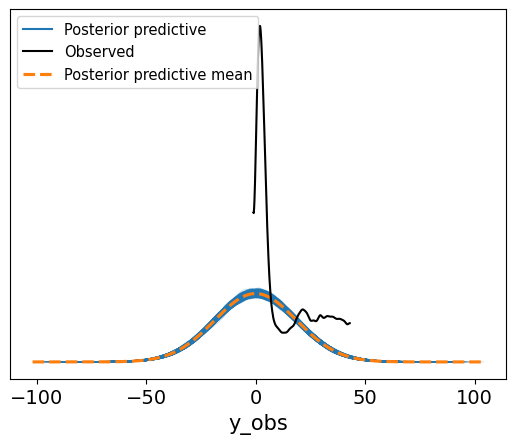

Sampling: [y_obs]


Output()

/Users/yiru/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


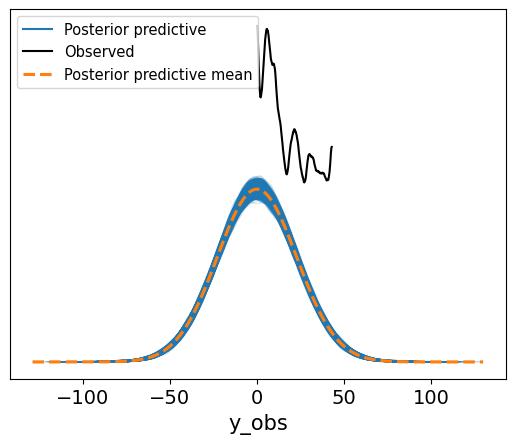

In [5]:
# Posterior predictive checks for entry model
with entry_model:
    ppc_entry = pm.sample_posterior_predictive(entry_trace)

# Merge posterior predictive data into InferenceData object
entry_trace.extend(ppc_entry)

# Plot PPC
az.plot_ppc(entry_trace)
plt.show()

# Posterior predictive checks for permanence model
with permanence_model:
    ppc_permanence = pm.sample_posterior_predictive(permanence_trace)

# Merge posterior predictive data
permanence_trace.extend(ppc_permanence)

# Plot PPC
az.plot_ppc(permanence_trace)
plt.show()

### Q3: perform robust Bayesian Linear Regression

Let $p(\tau_i)$ be $\require{cancel} \textrm{gamma}\big(\tau_i | \alpha = \frac{\nu}{2}, \overset{\textrm{rate}\xcancel{\textrm{scale}}}{\beta = \frac{\nu}{2}}\big)$ and let $p(y_i|\boldsymbol \beta, \tau,\tau_i)$ be $\mathcal{N}(y_i | \textbf{X} \boldsymbol \beta, \overset{\textrm{precision}}{\tau \times \tau_i})$. 

- Return to your dataset and maniputate it to have some various outliers or find another dataset with some outlier data
- Use an appropriate prior for inference on $v$ if you have enough data to do so
- Use the posterior distributions of the $\tau_i$'s to identify data point "outliers" 
- Use the posterior distributions of the $\sigma_i^{-2} = \tau \times \tau_i$ to create posterior distribuitions of the **influence** (the diagonals of the $H$ "hat" matrix $X^\top (X^\top D X)^{-1} X$ where $D_{ij}=0$ and $D_{ii} = \sigma^2_i$) and compare and contras some example "outlier" versus "non outlier" data points

- Provide inference with Bayesian posterior analysis and report MCMC diagnostics

#### [Optional] Q3 Extra: measurement error models?

What if $\textbf{x}_i = \textbf{x}_i^{true} + \eta_i, \eta_i \sim \mathcal{MVN}(\textbf{0}, \Sigma)$ for some kind of measurement error covariance structure $\Sigma$ and $\mathcal N (y_i| \textbf{X}^{true}\boldsymbol \beta, \sigma)$?

In [6]:
import pandas as pd
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load NHL dataset
df = pd.read_csv("nhl_data.csv", low_memory=False)

# Select relevant columns
columns = ['time_to_entry', 'time_to_permanence', 'player_dob_quartiles',  'draft_overall', 'player_position', 'BMI', 'country', 'shootsCatches']
df = df[columns].dropna()

# One-hot encode categorical variables (e.g., league)
df = pd.get_dummies(df, columns=['player_dob_quartiles'], drop_first=True)
df = pd.get_dummies(df, columns=['player_position'], drop_first=True)
df = pd.get_dummies(df, columns=['country'], drop_first=True)
df = pd.get_dummies(df, columns=['shootsCatches'], drop_first=True)

# Introduce synthetic outliers: randomly inflate some players' time_to_entry
df['time_to_entry'] = df['time_to_entry'].astype(float)

np.random.seed(42)
outlier_indices = np.random.choice(df.index, size=int(0.05 * len(df)), replace=False)
df.loc[outlier_indices, 'time_to_entry'] *= np.random.uniform(2, 4, size=len(outlier_indices))

# Standardize predictors
scaler = StandardScaler()
X = scaler.fit_transform(df.drop(columns=['time_to_entry']))
y = df['time_to_entry'].values
n, p = X.shape

In [7]:
with pm.Model() as robust_model:
    # Priors
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    tau = pm.Gamma('tau', alpha=2, beta=2)  # Global precision
    nu = pm.Exponential('nu', 1/30)  # Degrees of freedom
    
    # Hierarchical precision (individual precisions)
    tau_i = pm.Gamma('tau_i', alpha=nu/2, beta=nu/2, shape=n)

    # Linear model
    mu = pm.math.dot(X, betas)
    
    # Likelihood with hierarchical precision
    y_obs = pm.Normal('y_obs', mu=mu, tau=tau * tau_i, observed=y)

    # Sampling
    robust_trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas, tau, nu, tau_i]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [8]:
# Extract posterior mean of tau_i
tau_i_means = robust_trace.posterior['tau_i'].mean(dim=("chain", "draw")).values

# Identify potential outliers (lowest tau_i)
outlier_threshold = np.percentile(tau_i_means, 10)  # Bottom 10%
outliers = np.where(tau_i_means < outlier_threshold)[0]

# Print some potential outlier indices
print("Potential Outlier Indices:", outliers[:10])

Potential Outlier Indices: [ 3  8 22 31 33 35 39 47 70 74]


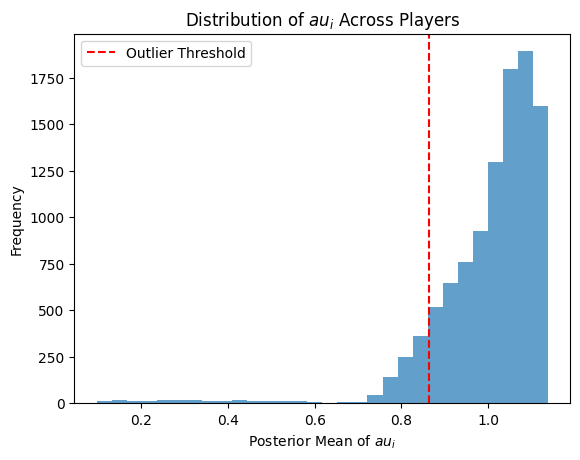

In [9]:
plt.hist(tau_i_means, bins=30, alpha=0.7)
plt.axvline(outlier_threshold, color='red', linestyle='--', label='Outlier Threshold')
plt.xlabel("Posterior Mean of $\tau_i$")
plt.ylabel("Frequency")
plt.legend()
plt.title("Distribution of $\tau_i$ Across Players")
plt.show()

In [ ]:
# MCMC Diagnostics
print(az.summary(robust_trace, hdi_prob=0.95))
az.plot_trace(robust_trace)
plt.show()

In [ ]:
with pm.Model() as measurement_error_model:
    # Latent true X (assumed Gaussian noise on observed X)
    X_true = pm.Normal('X_true', mu=X, sigma=0.1, shape=X.shape)
    
    # Priors
    betas = pm.Normal('betas', mu=0, sigma=1, shape=p)
    tau = pm.Gamma('tau', alpha=2, beta=2)
    tau_i = pm.Gamma('tau_i', alpha=nu/2, beta=nu/2, shape=n)

    # Linear model
    mu = pm.math.dot(X_true, betas)

    # Likelihood with hierarchical precision
    y_obs = pm.Normal('y_obs', mu=mu, tau=tau * tau_i, observed=y)

    # Sampling
    measurement_trace = pm.sample(2000, tune=1000, return_inferencedata=True)